In [2]:
from sympy import symbols
import sympy as sp
import numpy as np
from sympy.utilities.lambdify import lambdify, lambdastr
from matplotlib import pyplot as plt
from functools import cache

In [3]:
a_1 = 0.0134
b_1 = 1
c_1 = 4.35 * 10e-4
m_1 = 1
alpha_0 = 1.94 * 10e-2
delta = 1.5 * 10e3
gamma = 0.2 * 10e-2
l = 10
T_0 = 300
R = 0.5
F_0 = 50
X = sp.Symbol('x')
T = sp.Function('T')(X)
y_i_prev, y_i, y_i_next = symbols('y_p, y_i, y_n')

In [4]:
alpha = alpha_0 * (y_i / delta - 1) ** 4 + gamma
p = 2 / R * alpha
f = 2 * T_0 / R * alpha
k = a_1 * (b_1 + c_1 * y_i ** m_1)
k_prev = k.subs(y_i, y_i_prev)
k_next = k.subs(y_i, y_i_next)

In [5]:
alpha, p, f, k

(0.194*(6.66666666666667e-5*y_i - 1)**4 + 0.02,
 0.776*(6.66666666666667e-5*y_i - 1)**4 + 0.08,
 232.8*(6.66666666666667e-5*y_i - 1)**4 + 24.0,
 5.829e-5*y_i + 0.0134)

In [6]:
n = 100
h = l / n
x = np.linspace(0, l, n+1, endpoint=True)

In [7]:
def get_a_i(i):
    if i == 0:
        return sp.Float(0)
    return (k_prev + k) / 2

def get_b_i(i):
    if i == 0:
        return (k + k_next) / 2
    if i == n:
        return (k_prev + k) / 2 + p * h ** 2 + alpha * h
    return (k_prev + k) / 2 + (k + k_next) / 2 + p * h ** 2

def get_c_i(i):
    if i == 0:
        return (k + k_next) / 2
    if i == n:
        return sp.Float(0)
    return (k + k_next) / 2

def get_d_i(i):
    if i == 0:
        return f * h ** 2 + F_0 * h
    if i == n:
        return f * h ** 2 + alpha * T_0 * h
    return f * h ** 2

In [8]:
y = np.full(n+2, T_0)
A_prime = np.zeros_like(x)
B_prime = np.zeros_like(x)
C_prime = np.zeros_like(x)
D_prime = np.zeros_like(x)
A_lambdas = [None for i in range(n+1)]
B_lambdas = [None for i in range(n+1)]
C_lambdas = [None for i in range(n+1)]
D_lambdas = [None for i in range(n+1)]
lambdas = [A_lambdas, B_lambdas, C_lambdas, D_lambdas]

In [9]:
def my_lambdify(func):
    return lambdify([y_i_prev, y_i, y_i_next], func)

In [10]:
prev_strings = ["", "", "", ""]
for i, x_i in enumerate(x):
    A_i = get_a_i(i)
    B_i = get_b_i(i)
    C_i = get_c_i(i)
    D_i = get_d_i(i)

    G_i = A_i * y_i_prev + B_i * y_i - C_i * y_i_next + D_i

    A_func = sp.diff(G_i, y_i_prev)
    B_func = -sp.diff(G_i, y_i)
    C_func = sp.diff(G_i, y_i_next)
    D_func = G_i
    funcs = [A_func, B_func, C_func, D_func]

    for j in range(4):
        lamb_str = lambdastr([y_i_prev, y_i, y_i_next], funcs[j]) 
        if str == prev_strings[j]:
            lambdas[j][i] = lambdas[j][i-1]
        else:
            lambdas[j][i] = my_lambdify(funcs[j])
        prev_strings[j] = lamb_str

In [14]:
while True:
    for i, x_i in enumerate(x):
        A_prime[i] = A_lambdas[i](y[i-1], y[i], y[i+1])
        B_prime[i] = B_lambdas[i](y[i-1], y[i], y[i+1])
        C_prime[i] = C_lambdas[i](y[i-1], y[i], y[i+1])
        D_prime[i] = D_lambdas[i](y[i-1], y[i], y[i+1])

    eta = np.zeros_like(x)
    xi = np.zeros_like(x)
    delta_y = np.zeros_like(y)

    for i in range(1, n+1):
        xi[i] = C_prime[i-1] / (B_prime[i-1] - A_prime[i-1] * xi[i-1])
        eta[i] = (A_prime[i-1] * eta[i-1] + D_prime[i-1]) / (B_prime[i-1] - A_prime[i-1] * xi[i-1])

    for i in reversed(range(1, n+1)):
        if i == n:
            delta_y[n] = (A_prime[n] * eta[n] + D_prime[n]) / (B_prime[n] - A_prime[n] * xi[n])
        else:
            delta_y[i] = xi[i+1] * delta_y[i+1] + eta[i+1]

    for i in range(1, n):
        y[i] = y[i-1] + delta_y[i]
    
    print(delta_y)

    m = np.argmax(abs(delta_y / y))
    if m < 0.001:
        break

[             0          -1362          24543          29874
          57504          74117          29059          21846
          29957          39758          49857          60378
          71587          83776          97287         112556
         130162         150885         175775         206248
         244186         292084         353208         431793
         533280         664584         834408        1053604
        1335573        1696714        2156917        2740097
        3474760        4394593        5539059        6953988
        8692109       10813522       13386021       16485248
       20194577       24604659       29812533       35920190
       43032492       51248942       60665441       71369783
       83436359       96920252      111851105      128227426
      146012684      165134636      185490754      206963575
      229451485      252922699      277503173      303613202
      332172680      364901937      404754120      456526840
      527716111      629

KeyboardInterrupt: 

In [182]:

for i in range(1, n):
    y_final[i] = y_final[i-1] + delta_y[i]

NameError: name 'y_final' is not defined

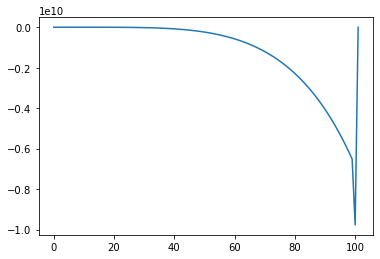

In [183]:
plt.plot(delta_y)

In [168]:
delta_y

array([   179815,   -165313,      -761,     22174,      5739,     -1757,
          -18443,    -47837,   -105896,   -226873,   -456044,   -796831,
        -1059435,  -1059425,  -1061867,  -1065463,  -1070223,  -1076148,
        -1083273,  -1091648,  -1101318,  -1112322,  -1124687,  -1138420,
        -1153520,  -1169970,  -1187751,  -1206841,  -1227222,  -1248880,
        -1271811,  -1296019,  -1321518,  -1348329,  -1376483,  -1406018,
        -1436977,  -1469412,  -1503381,  -1538944,  -1576170,  -1615131,
        -1655901,  -1698563,  -1743199,  -1789897,  -1838750,  -1889851,
        -1943299,  -1999196,  -2057645,  -2118755,  -2182638,  -2249406,
        -2319179,  -2392075,  -2468218,  -2547736,  -2630757,  -2717415,
        -2807846,  -2902189,  -3000586,  -3103183,  -3210129,  -3321577,
        -3437681,  -3558601,  -3684499,  -3815542,  -3951898,  -4093740,
        -4241246,  -4394596,  -4553974,  -4719568,  -4891570,  -5070177,
        -5255587,  -5448007,  -5647644,  -5854711, 

In [169]:
F_0

50